# Project 1 — Exploratory Data Analysis (EDA): Netflix Catalog

**Research question:** *How has Netflix’s content library evolved over time in terms of content type, genres, and geographic distribution?*

This notebook loads the Kaggle “Netflix Movies and TV Shows” dataset (Shivam Bansal), cleans key fields for analysis, and produces visualizations to explore trends over time.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load data (CSV provided)
df = pd.read_csv(r"C:\Users\aarav\OneDrive\Documents\DTSC2\netflix_titles.csv")
print("Shape:", df.shape)
df.head()

Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [7]:
# Basic structure + missingness
df.info()

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


director      2634
country        831
cast           825
date_added      10
rating           4
duration         3
dtype: int64

In [8]:
# Duplicates
df.duplicated().sum()

np.int64(0)

## Cleaning & Preparation (with decision notes)

Key decisions:
- Convert `date_added` to datetime and create `year_added` for time-based analysis.
- Fill missing categorical fields (`country`, `rating`) with **"Unknown"** to preserve rows while remaining transparent.
- Create `primary_country` by taking the first country listed (simplifies multi-country co-productions for grouping).
- Explode `listed_in` into individual genres so multi-genre titles count toward each genre.


In [9]:
df_clean = df.copy()

# Convert date_added to datetime (invalid/missing values become NaT)
df_clean["date_added"] = pd.to_datetime(df_clean["date_added"], errors="coerce")
df_clean["year_added"] = df_clean["date_added"].dt.year

# Fill missing categorical values with "Unknown"
df_clean["country"] = df_clean["country"].fillna("Unknown").astype("string").str.strip()
df_clean["rating"] = df_clean["rating"].fillna("Unknown").astype("string").str.strip()

# Normalize type + listed_in
df_clean["type"] = df_clean["type"].astype("string").str.strip()
df_clean["listed_in"] = df_clean["listed_in"].astype("string").str.strip()

# Primary country (first listed)
df_clean["primary_country"] = df_clean["country"].str.split(",").str[0].str.strip()

# Quick post-clean checks
df_clean[["type","date_added","year_added","country","primary_country","listed_in"]].head()

,type,date_added,year_added,country,primary_country,listed_in
0,Movie,2021-09-25,2021.0,United States,United States,Documentaries
1,TV Show,2021-09-24,2021.0,South Africa,South Africa,"International TV Shows, TV Dramas, TV Mysteries"
2,TV Show,2021-09-24,2021.0,Unknown,Unknown,"Crime TV Shows, International TV Shows, TV Act..."
3,TV Show,2021-09-24,2021.0,Unknown,Unknown,"Docuseries, Reality TV"
4,TV Show,2021-09-24,2021.0,India,India,"International TV Shows, Romantic TV Shows, TV ..."


In [10]:
# How many rows are missing year_added (missing/unparseable date_added)?
df_clean["year_added"].isna().sum()

np.int64(98)

## Visualization 1 — Titles Added Over Time

This shows how the *number of titles added to Netflix* changes over time (based on `date_added`).  
Rows with missing `year_added` are excluded from time-based charts.


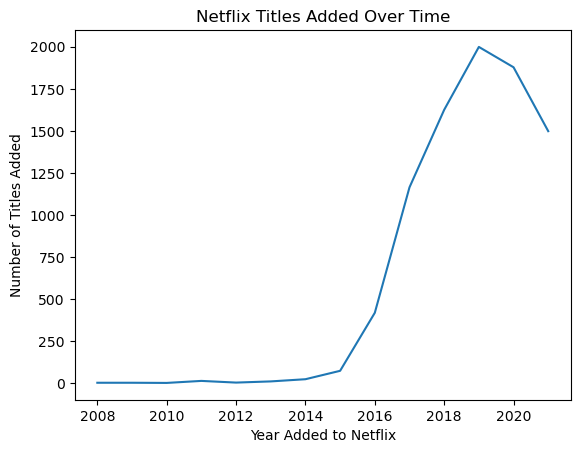

In [11]:
year_counts = df_clean.dropna(subset=["year_added"])["year_added"].value_counts().sort_index()

plt.figure()
plt.plot(year_counts.index, year_counts.values)
plt.xlabel("Year Added to Netflix")
plt.ylabel("Number of Titles Added")
plt.title("Netflix Titles Added Over Time")
plt.show()

## Visualization 2 — Movies vs TV Shows Over Time

This compares how the mix of Movies vs TV Shows added changes year by year.


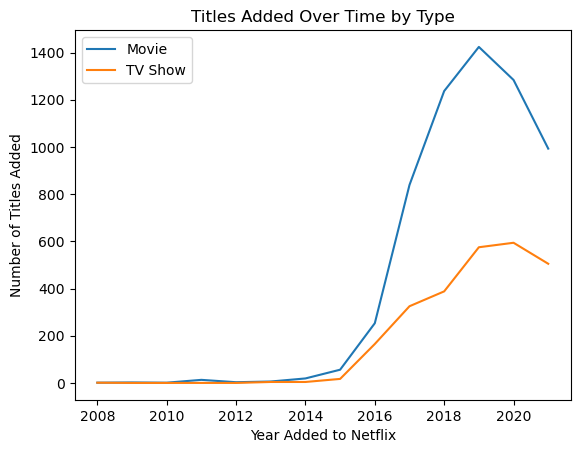

type,Movie,TV Show
year_added,,
2017.0,839.0,325.0
2018.0,1237.0,388.0
2019.0,1424.0,575.0
2020.0,1284.0,594.0
2021.0,993.0,505.0


In [12]:
type_by_year = (
    df_clean.dropna(subset=["year_added"])
    .pivot_table(index="year_added", columns="type", values="show_id", aggfunc="count")
    .fillna(0)
)

plt.figure()
for col in type_by_year.columns:
    plt.plot(type_by_year.index, type_by_year[col], label=col)

plt.xlabel("Year Added to Netflix")
plt.ylabel("Number of Titles Added")
plt.title("Titles Added Over Time by Type")
plt.legend()
plt.show()

type_by_year.tail()

## Visualization 3 — Top Countries by Titles

To simplify analysis of multi-country titles, we use `primary_country` (the first listed country). This does **not** fully represent co-productions, but it provides consistent grouping.


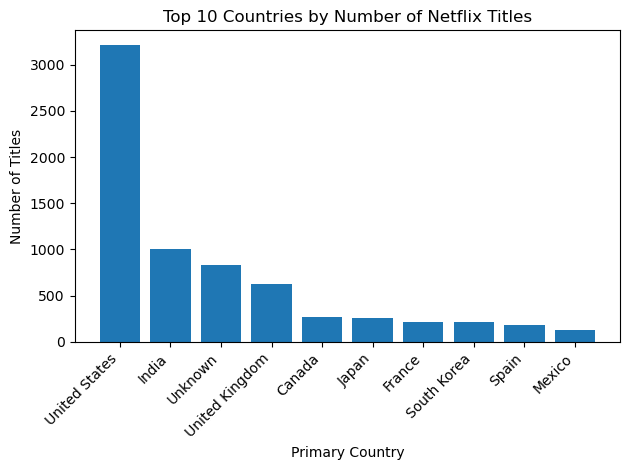

primary_country
United States     3211
India             1008
Unknown            831
United Kingdom     628
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Name: count, dtype: int64

In [13]:
top_countries = df_clean["primary_country"].value_counts().head(10)

plt.figure()
plt.bar(top_countries.index, top_countries.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Primary Country")
plt.ylabel("Number of Titles")
plt.title("Top 10 Countries by Number of Netflix Titles")
plt.tight_layout()
plt.show()

top_countries

## Visualization 4 — Country Trends Over Time (Top 5)

This explores whether the biggest contributing countries change across years.


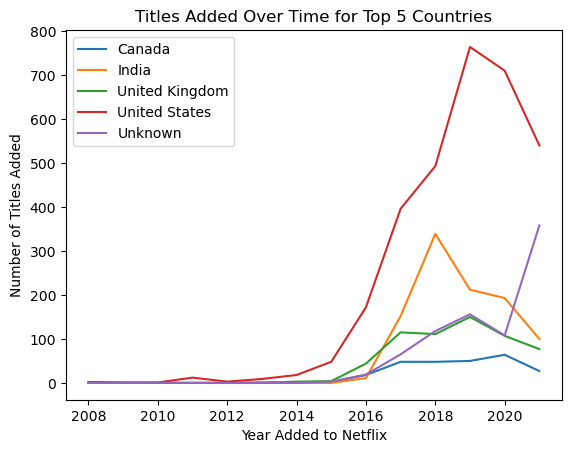

primary_country,Canada,India,United Kingdom,United States,Unknown
year_added,,,,,
2017.0,48.0,152.0,115.0,396.0,65.0
2018.0,48.0,339.0,111.0,493.0,118.0
2019.0,50.0,212.0,150.0,764.0,156.0
2020.0,64.0,193.0,107.0,710.0,108.0
2021.0,27.0,100.0,77.0,540.0,358.0


In [14]:
top5 = df_clean["primary_country"].value_counts().head(5).index.tolist()

country_year = (
    df_clean[df_clean["primary_country"].isin(top5)]
    .dropna(subset=["year_added"])
    .pivot_table(index="year_added", columns="primary_country", values="show_id", aggfunc="count")
    .fillna(0)
)

plt.figure()
for c in country_year.columns:
    plt.plot(country_year.index, country_year[c], label=c)

plt.xlabel("Year Added to Netflix")
plt.ylabel("Number of Titles Added")
plt.title("Titles Added Over Time for Top 5 Countries")
plt.legend()
plt.show()

country_year.tail()

## Visualization 5 — Top Genres (Exploded)

`listed_in` contains multiple genres separated by commas. Exploding prevents multi-genre strings from being treated as a single category.


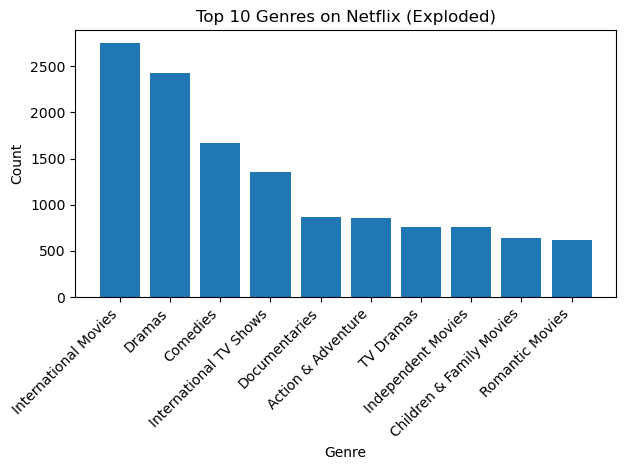

genre
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: Int64

In [15]:
df_genres = df_clean.assign(
    genre=df_clean["listed_in"].str.split(",")
).explode("genre")

df_genres["genre"] = df_genres["genre"].astype("string").str.strip()

top_genres = df_genres["genre"].value_counts().head(10)

plt.figure()
plt.bar(top_genres.index, top_genres.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top 10 Genres on Netflix (Exploded)")
plt.tight_layout()
plt.show()

top_genres

## Visualization 6 — Top Genres by Content Type

This compares whether the most common genres differ between Movies and TV Shows.


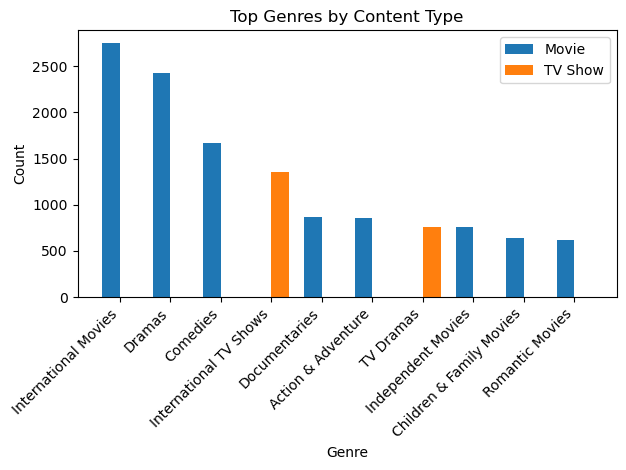

type,Movie,TV Show
genre,,
International Movies,2752.0,0.0
Dramas,2427.0,0.0
Comedies,1674.0,0.0
International TV Shows,0.0,1351.0
Documentaries,869.0,0.0
Action & Adventure,859.0,0.0
TV Dramas,0.0,763.0
Independent Movies,756.0,0.0
Children & Family Movies,641.0,0.0


In [16]:
top_genre_list = top_genres.index.tolist()

genre_type = (
    df_genres[df_genres["genre"].isin(top_genre_list)]
    .pivot_table(index="genre", columns="type", values="show_id", aggfunc="count")
    .fillna(0)
)

# Keep a consistent order: sort by total across types
genre_type["Total"] = genre_type.sum(axis=1)
genre_type = genre_type.sort_values("Total", ascending=False).drop(columns=["Total"])

plt.figure()
x = np.arange(len(genre_type.index))
width = 0.35

types = genre_type.columns.tolist()
if len(types) == 2:
    plt.bar(x - width/2, genre_type[types[0]].values, width, label=types[0])
    plt.bar(x + width/2, genre_type[types[1]].values, width, label=types[1])
else:
    for i, t in enumerate(types):
        plt.bar(x + (i - len(types)/2)*width, genre_type[t].values, width, label=t)

plt.xticks(x, genre_type.index, rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top Genres by Content Type")
plt.legend()
plt.tight_layout()
plt.show()

genre_type

## Quick summary tables (optional but helpful for write-up)

These tables support the narrative (counts and proportions).


In [17]:
# Overall mix of content type
type_counts = df_clean["type"].value_counts()
type_props = (type_counts / type_counts.sum()).round(3)
type_counts, type_props

(type
 Movie      6131
 TV Show    2676
 Name: count, dtype: Int64,
 type
 Movie      0.696
 TV Show    0.304
 Name: count, dtype: Float64)

In [18]:
# Most common ratings (overall)
df_clean["rating"].value_counts().head(10)

rating
TV-MA    3207
TV-14    2160
TV-PG     863
R         799
PG-13     490
TV-Y7     334
TV-Y      307
PG        287
TV-G      220
NR         80
Name: count, dtype: Int64

## Interpretation Notes (to turn into portfolio narrative)

Use your chart outputs to write 2–5 sentences per visualization:
- What the chart shows (specific trend).
- What a reasonable explanation *could* be (not claiming certainty).
- What you cannot conclude from the data alone.

Then finish with limitations + ethics + reflection:
- Catalog-only dataset (not the whole industry).
- Missingness in country/cast/director fields.
- “Primary country” simplification.
- Platform-defined genres and ratings.
- Potential bias in licensing and global representation.
